`Aim:` *Notebook for the purpose of Climate Risk Assessment lecture:* `Xarray and Climate Indices`

`Author:` Yannick Barton, Martin Aregger, Hugo Banderier

`Notes:` Remeber `del` command to free up memory when a python object is not used anymore !

# IMPORTANT This week's data

Keep the temperature data from two weeks ago with you, you can also use it!

This week, we mostly work with precip data, that you can **download from this link**:

https://filesender.switch.ch/filesender2/?s=download&token=5825d882-8f7c-4e7b-845c-f3048f50ffe3

# Imports

In [2]:
from IPython.display import Image
import numpy as np
import xarray as xr

# Quantiles

Quantiles are cut points dividing the range of observations into continuous intervals or groups with equal observations.

There is one fewer quantile than the number of groups created.

Common quantiles have special names, such as <b>quartiles</b> (four groups), <b>deciles</b> (ten groups), and <b>percentiles</b> (100 groups).

For example, quantile 0.5 divides the observations into 2 subsets of equal size (50%). It is commonly referred to as the <b>median</b>. It is equivalent to the 50th percentile.

Quantile 0.9, or the 90th percentile, is the treshold above which the top 10% highest values are located.

On the other hand, quantile 0.1, or the 10th percentile, is the treshold below which the 10% lowest values can be found.

This makes them a very natural tool to look at extreme values in a distribution and detect extreme events like hot spells in climate data.

In [2]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/5/5e/Iqr_with_quantile.png")


Quantiles can be used as a measure of the spread of the data. A common measure for the spread is the <b>interquartile range</b> (IQR).

IQR is defined as the difference between the upper and lower quartiles (Q3 − Q1) and contains 50% of the data.

If IQR is large, then the spread of the data is large and we expect a large standard deviation.

## Example: comparing precipitation quantiles

### Read data

In [ ]:
# let's read in rain data
input_file = (
    "PATH_TO_YOUR/RAIN_FILE.nc"
)

# let's load the data by using open_dataset function of xarray
ds_pr = (
    xr.open_dataset(
        input_file, chunks={"member_id": 1, "time": 2 * 365, "lon": -1, "lat": -1}
    )
    .rename({"RAIN": "pr"})
    .load()
)


In [29]:
ds_pr  # let's have a look at the data inside that file


<xarray.Dataset> Size: 2GB
Dimensions:      (member_id: 10, time: 10950, lat: 64, lon: 57, hist_interval: 2)
Coordinates:
  * lat          (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * member_id    (member_id) <U12 480B 'r10i1231p1f1' ... 'r2i1251p1f1'
  * time         (time) datetime64[ns] 88kB 1970-01-01T12:00:00 ... 1999-12-3...
    time_bounds  (time, hist_interval) object 175kB 1970-01-01 00:00:00 ... 2...
  * lon          (lon) float32 228B -30.0 -28.75 -27.5 ... 37.5 38.75 40.0
Dimensions without coordinates: hist_interval
Data variables:
    pr           (member_id, time, lat, lon) float32 2GB nan nan nan ... nan nan
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

In [30]:
ds_pr.pr.attrs  # we need to check the precipitation units before we start


{'cell_methods': 'time: mean',
 'long_name': 'atmospheric rain, after rain/snow repartitioning based on temperature',
 'units': 'mm/s'}

Interesting, precipitation is given as a flux! Often precipitation data in reanalysis is expressed as a flux, that is in kg m-2 s-1.

### Pre-process data

Let's convert the precipitation flux to daily precipitation rate (mm/day).

- 1 kg of rain over 1 m-2 is equivalent to 1 mm

Therefore, to convert to mm/day, one has to multiply the flux currently in seconds by 60 * 60 * 24 = 86400

In [31]:
pr_mm = (
    ds_pr.pr * 86400
)  # we convert the precipitation data to mm/day and store the result in a new Data Array
pr_mm.attrs["units"] = "mm/day"  # it is better to modify the attributes as well


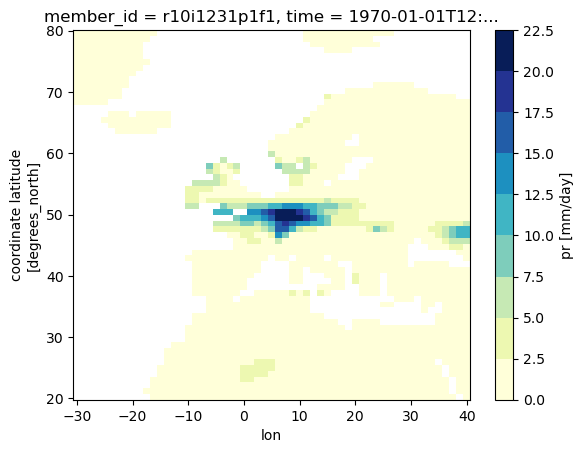

In [ ]:
pr_mm.isel(time=0, member_id=0).plot(
    cmap="YlGnBu", levels=11
)  # let's plot the first time step of our variable


### Compute the local median (50th percentile)

In [33]:
pr_mm.quantile(q=0.50)


<xarray.DataArray 'pr' ()> Size: 8B
array(0.00249575)
Coordinates:
    quantile  float64 8B 0.5

Oops! If you don't specify the dimension over which to compute the quantile, you we get a global value for the quantile over the entire domain.

In [34]:
# specify the dimension over which to compute any statistical quantity such as quantiles
pr_q50 = pr_mm.quantile(q=0.5, dim=["time", "member_id"])


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


(64, 57)


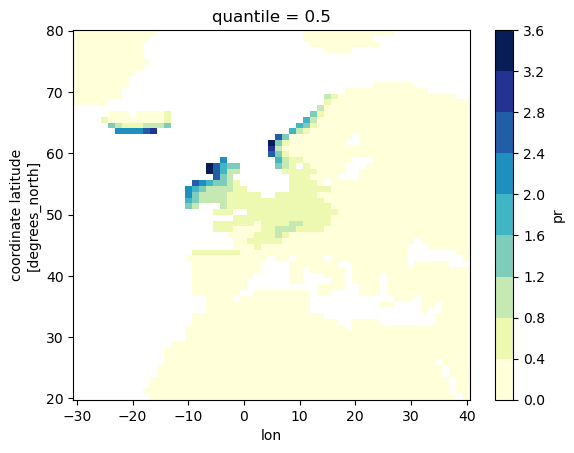

In [35]:
# we expect a 2D array
print(pr_q50.shape)
pr_q50.plot(cmap="YlGnBu", levels=11)


In [ ]:
# Like most xarray functions you could also have chosen several dimensions using a list or a tuple
pr_median_space = pr_mm.median(dim=["lon", "lat"])  # dim=('lon', 'lat') also works

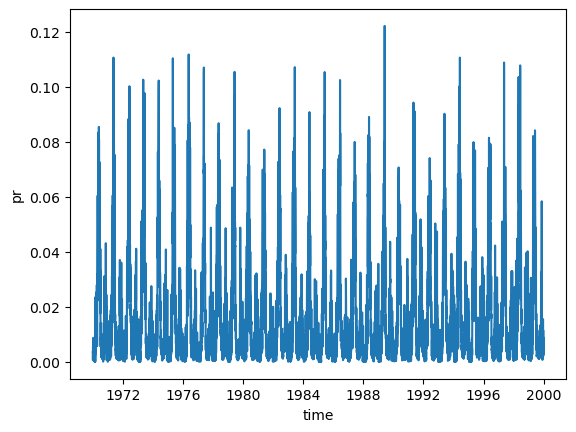

In [131]:
pr_median_space.mean("member_id").plot()

### Compute the IQR (75th - 25th percntile)

In [39]:
pr_q25 = pr_mm.quantile(q=0.25, dim=["time", "member_id"])  # 25th percentile
pr_q75 = pr_mm.quantile(q=0.75, dim=["time", "member_id"])  # 75th percentile


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [40]:
pr_iqr = pr_q75 - pr_q25  # interquartile range (IQR)


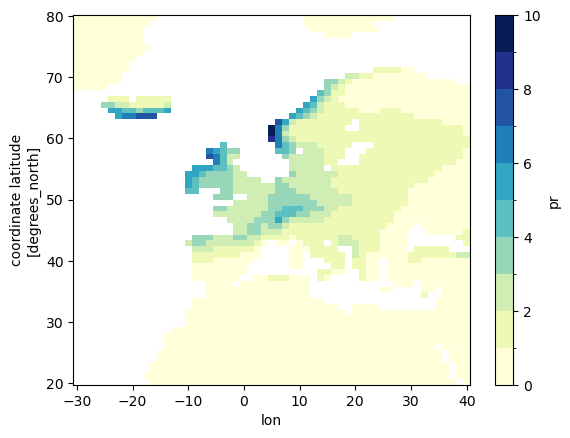

In [42]:
pr_iqr.plot(cmap="YlGnBu", levels=11)  # let's plot the IQR


### Compare the IQR with the standard deviation

In [44]:
pr_std = pr_mm.std(
    dim=["time", "member_id"]
)  # compute the standard deviation; don't forget to specify the dimension


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


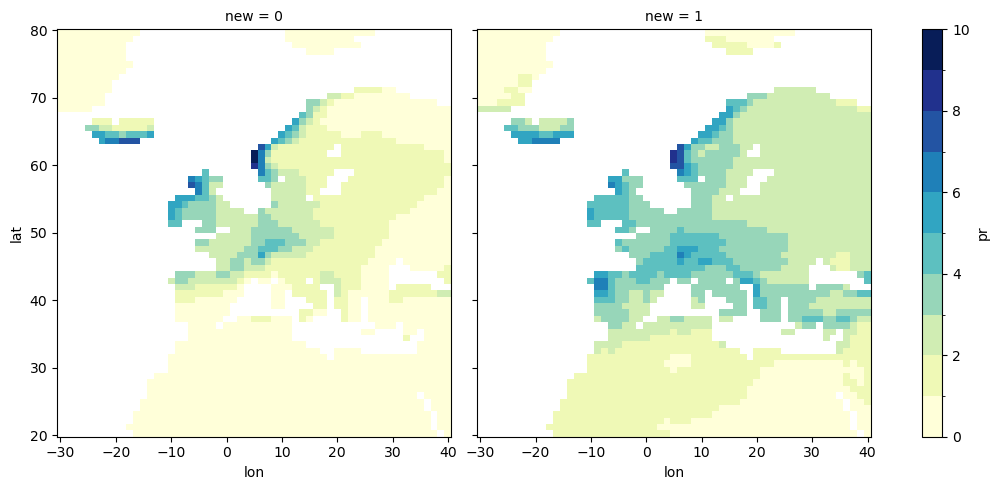

In [ ]:
xr.concat([pr_iqr, pr_std], dim="new").plot(
    col="new", cmap="YlGnBu", levels=11, figsize=(11, 5)
)


From the figure above, we observe that the spatial patterns between the IQR and STD are similar. Differences may be related to the skewed distribution of rainfall values.

# Masking

Using masking concept allows to transform the data to binary values that are True/False based upon one or multiple conditions. The idea behind masking is to 'mask', hide or ignore data values that do not meet a desired condition.

Examples:

- Select only days of a specific season or time period

- Find days with minimum temperature below 0°C

- Find days with precipitation sums above the extreme 99th wet percentile

- ...

Masking can by applied similarly to time-series as well as multi-dimensional data

Binary arrays such as masks contain TRUE/FALSE values, but if plotted it shows 1 for TRUE and 0 for FALSE ! This happens thanks to implicit type conversion

## Example: find the number of extreme rainfall days (> 50 mm)

In [50]:
# We re-use the precipitation file that we have previously converted to mm/day
pr_mm


<xarray.DataArray 'pr' (member_id: 10, time: 10950, lat: 64, lon: 57)> Size: 2GB
array([[[[           nan,            nan,            nan, ...,
          4.43631411e-03,            nan, 2.63119890e-11],
         [           nan,            nan,            nan, ...,
                     nan, 5.94387348e-06, 1.22781568e-11],
         [           nan,            nan,            nan, ...,
                     nan, 5.44937029e-06, 8.16838819e-11],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
          6.63230186e-14,            nan, 1.44532775e-10],
         [           nan,            nan,            nan, ...,
                     nan, 1.31448549e-13, 3.47016721e-11],
         [           nan,            nan,            nan, ...,
                     nan, 3.11306678e-08, 3.66173403e-08],
...
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
          1.22417530e-14,            nan, 5.42579176e-11],
         [           nan,            nan,            nan, ...,
                     nan, 1.58131982e-07, 3.36853462e-12],
         [           nan,            nan,            nan, ...,
                     nan, 2.88126897e-14, 5.63806225e-07],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]]]],
      shape=(10, 10950, 64, 57), dtype=float32)
Coordinates:
  * lat        (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * member_id  (member_id) <U12 480B 'r10i1231p1f1' ... 'r2i1251p1f1'
  * time       (time) datetime64[ns] 88kB 1970-01-01T12:00:00 ... 1999-12-31T...
  * lon        (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
Attributes:
    units:    mm/day

In [92]:
temp_mask = pr_mm > 50  # gives true and false values (which is our mask)


In [93]:
# we could use the mask to extract data values that are True, however it is not needed for this example
count = temp_mask.sum().values  # we simply add up all True values
print(
    "Total number of days, all grid-points and members confounded, with daily rainfall above 50 mm are {}".format(
        count
    )
)


Total number of days, all grid-points and members confounded, with daily rainfall above 50 mm are 8806


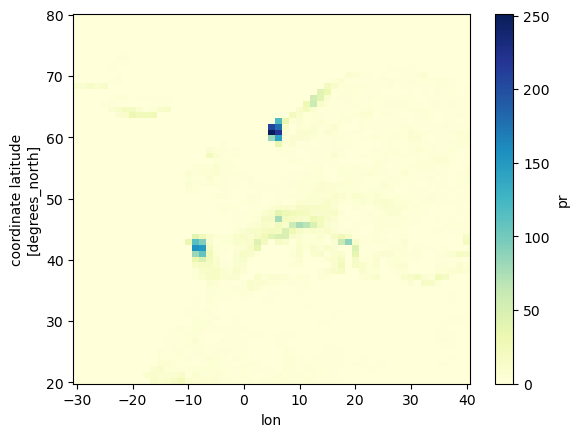

In [ ]:
# but we are interested in the local 'per-grid-point' count of days, so we need to specify to sum over the time dim
temp_mask.sum(dim=["time", "member_id"]).plot(
    cmap="YlGnBu"
)  # Sum up True values and plot the result


Note that the label on the color bar is wrong since xarray just uses the label from original precipitation file.

You can pass the following argument to change the label to your taste: cbar_kwargs={"label": "number of days"}

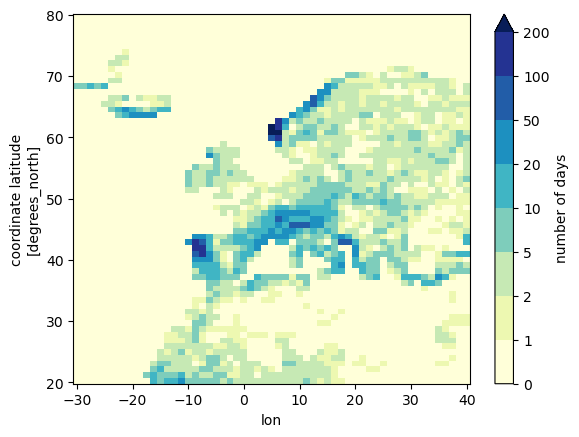

In [ ]:
# quick customization
temp_mask.sum(dim=["time", "member_id"]).plot(
    levels=[0, 1, 2, 5, 10, 20, 50, 100, 200],
    cbar_kwargs={"label": "number of days"},
    cmap="YlGnBu",
)


# A more advanced example: seasonal heavy rainfall thresholds

Let's apply what we have learned so far about quantiles and masks through a more complex example to determine seasonal heavy (90th percentile) rainfall days. We will use the same precipitation file as above, already converted in mm/day.

In [135]:
pr_mm


<xarray.DataArray 'pr' (member_id: 10, time: 10950, lat: 64, lon: 57)> Size: 2GB
array([[[[           nan,            nan,            nan, ...,
          4.43631411e-03,            nan, 2.63119890e-11],
         [           nan,            nan,            nan, ...,
                     nan, 5.94387348e-06, 1.22781568e-11],
         [           nan,            nan,            nan, ...,
                     nan, 5.44937029e-06, 8.16838819e-11],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
          6.63230186e-14,            nan, 1.44532775e-10],
         [           nan,            nan,            nan, ...,
                     nan, 1.31448549e-13, 3.47016721e-11],
         [           nan,            nan,            nan, ...,
                     nan, 3.11306678e-08, 3.66173403e-08],
...
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
          1.22417530e-14,            nan, 5.42579176e-11],
         [           nan,            nan,            nan, ...,
                     nan, 1.58131982e-07, 3.36853462e-12],
         [           nan,            nan,            nan, ...,
                     nan, 2.88126897e-14, 5.63806225e-07],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                     nan,            nan,            nan]]]],
      shape=(10, 10950, 64, 57), dtype=float32)
Coordinates:
  * lat        (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * member_id  (member_id) <U12 480B 'r10i1231p1f1' ... 'r2i1251p1f1'
  * time       (time) datetime64[ns] 88kB 1970-01-01T12:00:00 ... 1999-12-31T...
  * lon        (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
Attributes:
    units:    mm/day

## Select periods of interest

### a) using a mask

In [136]:
# create a time mask; returns True or False values
time_mask_winter = pr_mm.time.dt.month.isin(
    [12, 1, 2]
)  # isin selects timestamps that belong to months 12, 1 and 2
time_mask_spring = pr_mm.time.dt.month.isin(
    [3, 4, 5]
)  # isin selects timestamps that belong to months 3, 4 and 5
time_mask_summer = pr_mm.time.dt.month.isin(
    [6, 7, 8]
)  # isin selects timestamps that belong to months 6, 7 and 8
time_mask_autumn = pr_mm.time.dt.month.isin(
    [9, 10, 11]
)  # isin selects timestamps that belong to months 9, 10 and 11


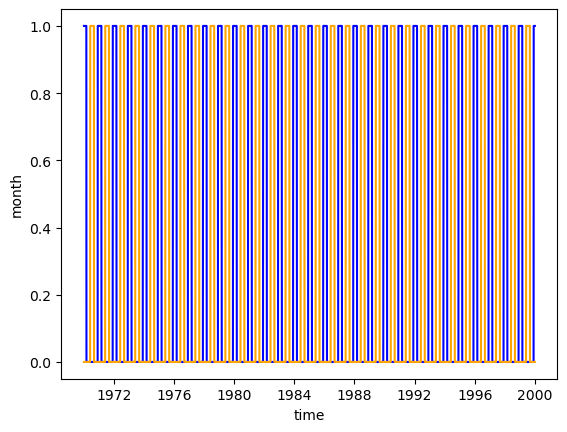

In [102]:
# let's check the masks by plotting them
time_mask_winter.plot(color="blue")
time_mask_summer.plot(color="orange")


In [103]:
# we apply the mask on the second dimension, since we mask time
pr_DJF_masked = pr_mm[:, time_mask_winter, :, :]
pr_MAM_masked = pr_mm[:, time_mask_spring, :, :]
pr_JJA_masked = pr_mm[:, time_mask_summer, :, :]
pr_SON_masked = pr_mm[:, time_mask_autumn, :, :]


In [105]:
print(pr_mm.shape)  # 10950 time steps
print(pr_DJF_masked.shape)  # 451 2700 steps (only winter)


(10, 10950, 64, 57)
(10, 2700, 64, 57)


### b) using the built-in groupby function

In [106]:
pr_grouped_data = pr_mm.groupby(
    "time.season"
)  # many time-grouping possibilies: 'time.month', 'time.day', ...


In [107]:
pr_grouped_data


<DataArrayGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'season': 4/4 groups present with labels 'DJF', 'JJA', 'MAM', 'SON'>

`DataArrayGroupyBy` objects may look a bit confusing at first (and a bit outside the scope of this lesson) but they are extremely convenient. They are worth spending the time needed to understand them ! You can find a tutorial here https://docs.xarray.dev/en/stable/user-guide/groupby.html#groupby

## Determine heavy rainfall thresholds (90th percentile)

In [110]:
# compute the 90th percentile for the masked data
pr_DJF_q90_masked = pr_DJF_masked.quantile(0.9, dim=["time", "member_id"])
pr_MAM_q90_masked = pr_MAM_masked.quantile(0.9, dim=["time", "member_id"])
pr_JJA_q90_masked = pr_JJA_masked.quantile(0.9, dim=["time", "member_id"])
pr_SON_q90_masked = pr_SON_masked.quantile(0.9, dim=["time", "member_id"])


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [111]:
pr_DJF_q90_masked


<xarray.DataArray 'pr' (lat: 64, lon: 57)> Size: 15kB
array([[       nan,        nan,        nan, ..., 0.16745964,        nan,
        0.0261473 ],
       [       nan,        nan,        nan, ...,        nan, 0.02351486,
        0.0123359 ],
       [       nan,        nan,        nan, ...,        nan, 0.00993505,
        0.01309822],
       ...,
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan]], shape=(64, 57), dtype=float32)
Coordinates:
  * lat       (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon       (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
    quantile  float64 8B 0.9

In [112]:
# compute the 90th percentile for the grouped data and where rainfall values are at least 1 mm
pr_q90_grouped = pr_grouped_data.quantile(0.9, dim=["time", "member_id"])


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [113]:
pr_q90_grouped  # notice that the 90th percentile is computed for each of the 4 seasons separately


<xarray.DataArray 'pr' (season: 4, lat: 64, lon: 57)> Size: 58kB
array([[[           nan,            nan,            nan, ...,
         1.67459637e-01,            nan, 2.61473041e-02],
        [           nan,            nan,            nan, ...,
                    nan, 2.35148575e-02, 1.23359030e-02],
        [           nan,            nan,            nan, ...,
                    nan, 9.93505400e-03, 1.30982203e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         1.11847150e-03,            nan, 2.69208699e-02],
        [           nan,            nan,            nan, ...,
                    nan, 9.17117149e-02, 2.15008436e-03],
        [           nan,            nan,            nan, ...,
                    nan, 3.74074822e-04, 1.19692821e-03],
...
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         2.05931708e-01,            nan, 3.86998686e-03],
        [           nan,            nan,            nan, ...,
                    nan, 5.51008463e-01, 4.51933083e-05],
        [           nan,            nan,            nan, ...,
                    nan, 3.63691402e-06, 5.54826074e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan]]],
      shape=(4, 64, 57), dtype=float32)
Coordinates:
  * lat       (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon       (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
    quantile  float64 8B 0.9
  * season    (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

You can select the result for a season with `.sel(season='DJF')`

In [114]:
pr_q90_grouped.sel(season="DJF")


<xarray.DataArray 'pr' (lat: 64, lon: 57)> Size: 15kB
array([[       nan,        nan,        nan, ..., 0.16745964,        nan,
        0.0261473 ],
       [       nan,        nan,        nan, ...,        nan, 0.02351486,
        0.0123359 ],
       [       nan,        nan,        nan, ...,        nan, 0.00993505,
        0.01309822],
       ...,
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan]], shape=(64, 57), dtype=float32)
Coordinates:
  * lat       (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon       (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
    quantile  float64 8B 0.9
    season    <U3 12B 'DJF'

## Comparison masking vs grouping

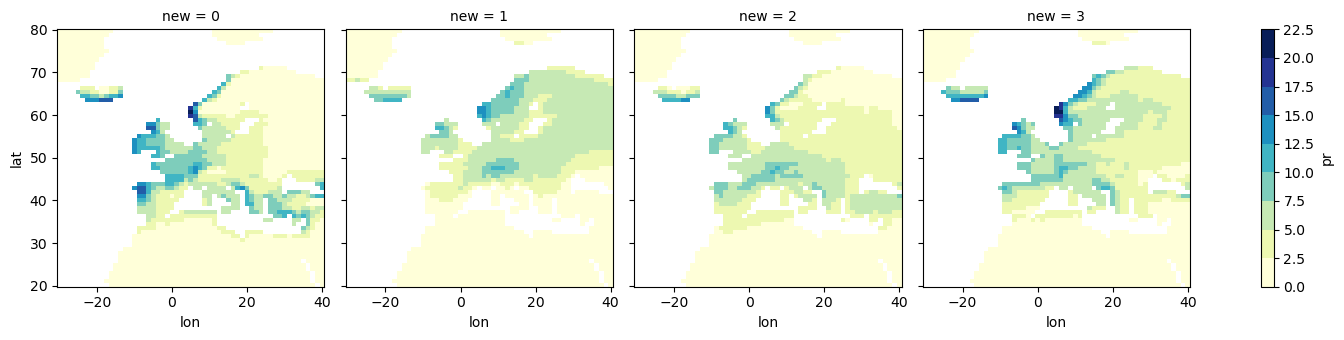

In [118]:
xr.concat(
    [pr_DJF_q90_masked, pr_JJA_q90_masked, pr_MAM_q90_masked, pr_SON_q90_masked],
    dim="new",
).plot(col="new", cmap="YlGnBu", levels=11, figsize=(15, 3.5))


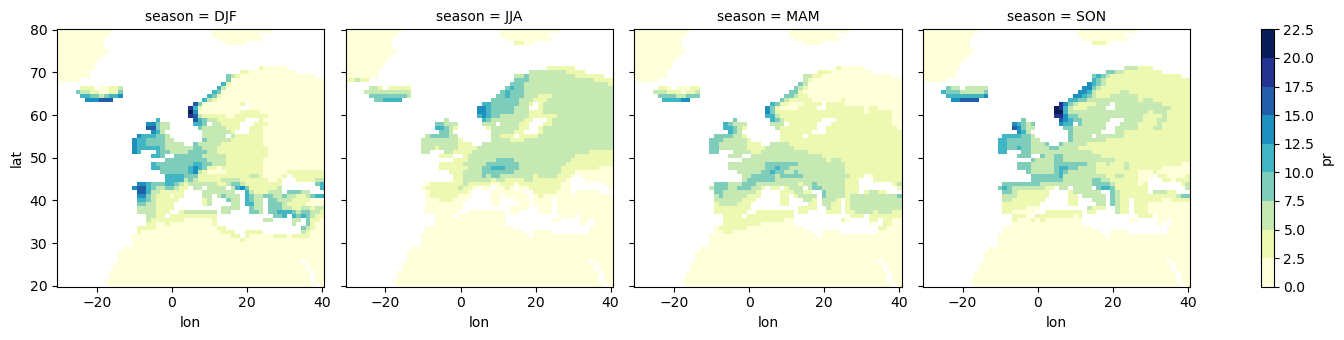

In [119]:
pr_q90_grouped.plot(col="season", cmap="YlGnBu", levels=11, figsize=(15, 3.5))


## Saving to NETCDF file

If you are happy with your results, you can store them to disk as a NETCDF file.

Sometimes it may be usefull to store intermediate steps to speed up computational time, especially when you are working with large amount of data.

In [ ]:
# 2D data array containing winter q90 values
pr_DJF_q90_masked


In [ ]:
# Just like for datasets, you can write data arrays
pr_DJF_q90_masked.to_netcdf("saved_on_disk.nc")


In [ ]:
# Let's read in the saved data array
ds_disk = xr.open_dataset("saved_on_disk.nc")


In [ ]:
ds_disk  # let's have a look at the data inside that file


Notice how xarray has automatically converted the data array to a dataset !

Your data array is now stored as a variable (pr).

## Conclusions

In [123]:
# a) using masking (has to be computed for each season seperatly)
pr_DJF_q90_masked = pr_mm[:, pr_mm.time.dt.month.isin([12, 1, 2]), :, :].quantile(
    0.9, dim=["time", "member_id"]
)
pr_MAM_q90_masked = pr_mm[:, pr_mm.time.dt.month.isin([3, 4, 5]), :, :].quantile(
    0.9, dim=["time", "member_id"]
)
pr_JJA_q90_masked = pr_mm[:, pr_mm.time.dt.month.isin([6, 7, 8]), :, :].quantile(
    0.9, dim=["time", "member_id"]
)
pr_SON_q90_masked = pr_mm[:, pr_mm.time.dt.month.isin([9, 10, 11]), :, :].quantile(
    0.9, dim=["time", "member_id"]
)

# b) using grouping (one line of code)
pr_q90_grouped = pr_mm.groupby("time.season").quantile(0.9, dim=["time", "member_id"])


/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


### Note 1

The code above computes the all-day 90th percentile.

You might be interested in the 'wet' percentile, that is considering the non-zero rainfall days of the distibution only!

Usually, a non-zero rainfall day, or commonly referred to as 'wet day' is defined as a day with at least 1 mm of precipitation.

Xarray's 'where' function allows you to subset a data array meeting given condition, returning an array with identical dimensions, where values that do not meet the condition are set to missing (nan).

But careful, 'where' does not do the same thing as masking! The function 'where' returns the actual values that are True whereas a mask only contains True/False values.

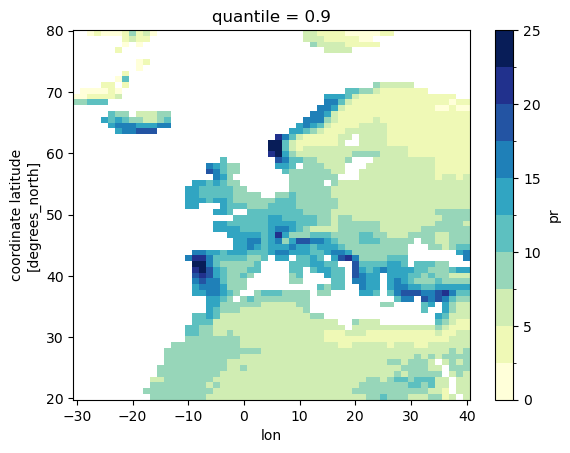

In [ ]:
# compute the 'wet' 90th percentile for the masked data where rainfall values are at least 1 mm
pr_q90_masked = pr_DJF_masked.where(pr_DJF_masked >= 1).quantile(
    0.9, dim=["time", "member_id"]
)
pr_q90_masked.plot(cmap="YlGnBu", levels=11)

### Note 2

Note that depedening on the research question, it would make more sense to choose a year round threshold instead of a seasonal one. This would be the case if you are interested in the impact relevance of extreme events and want to know when the most extreme events occur throughout the year (and would probably have less events in winter than in summer).

## Ensemble spread

It can be interesting to study how the model captures weather variability with the 10 members we have. One thing we can do is compute the daily ensemble spread averaged over all grid points

/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


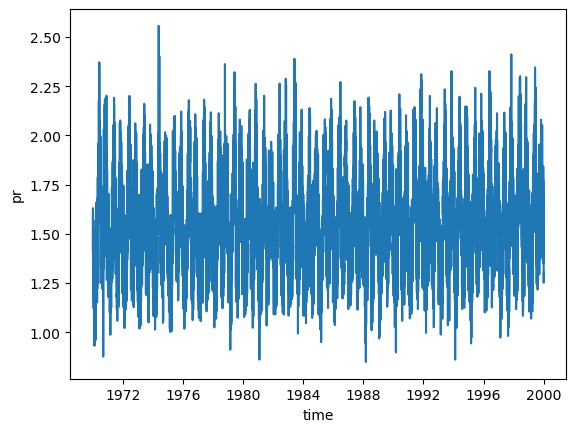

In [126]:
pr_mm.std("member_id").mean(["lon", "lat"]).plot()

Or the seasonal mean ensemble spread for each grid point

/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


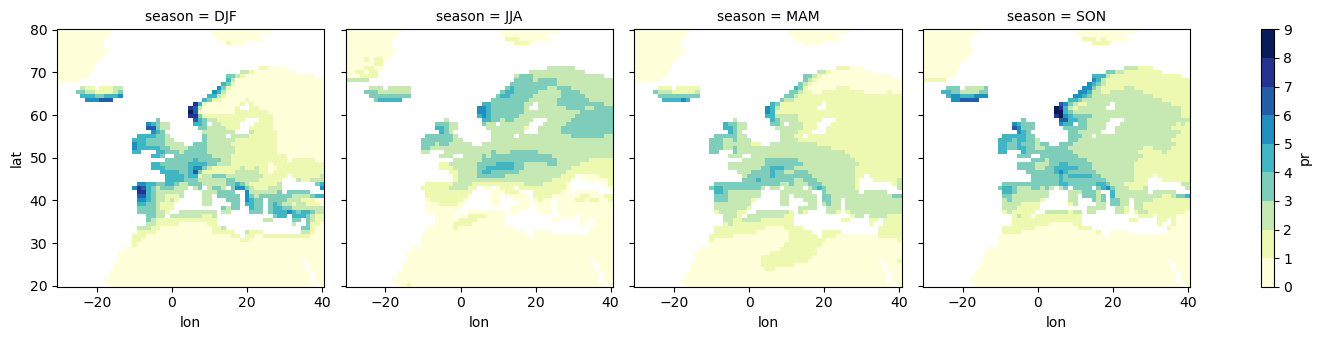

In [ ]:
pr_mm.std("member_id").groupby("time.season").mean("time").plot(
    col="season", cmap="YlGnBu", levels=11, figsize=(15, 3.5)
)

# Bonus \# 1: random xarray tricks

## `resample` for daily, monthly, yearly, ... means

In [ ]:
pr_mm.std("member_id").resample(time="1YE").mean()

/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'pr' (time: 30, lat: 64, lon: 57)> Size: 438kB
array([[[       nan,        nan,        nan, ..., 0.28709215,
                nan, 0.2838695 ],
        [       nan,        nan,        nan, ...,        nan,
         0.29104033, 0.2697539 ],
        [       nan,        nan,        nan, ...,        nan,
         0.18663597, 0.27794358],
        ...,
        [0.01067758, 0.01361231, 0.01768399, ...,        nan,
                nan,        nan],
        [0.0126159 , 0.0186462 , 0.02907758, ...,        nan,
                nan,        nan],
        [0.01210217, 0.01759901, 0.02680003, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.29392084,
                nan, 0.21225768],
        [       nan,        nan,        nan, ...,        nan,
         0.27567217, 0.2164249 ],
        [       nan,        nan,        nan, ...,        nan,
         0.19076377, 0.2579834 ],
...
        [0.01718838, 0.02106135, 0.02767801, ...,        nan,
                nan,        nan],
        [0.02145954, 0.02861177, 0.04347549, ...,        nan,
                nan,        nan],
        [0.02270726, 0.02907393, 0.03908639, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.20898287,
                nan, 0.16886187],
        [       nan,        nan,        nan, ...,        nan,
         0.21569596, 0.1754373 ],
        [       nan,        nan,        nan, ...,        nan,
         0.16117567, 0.22452223],
        ...,
        [0.03609407, 0.03840126, 0.04236123, ...,        nan,
                nan,        nan],
        [0.0529559 , 0.06496334, 0.07295494, ...,        nan,
                nan,        nan],
        [0.05088864, 0.06429327, 0.07512837, ...,        nan,
                nan,        nan]]], shape=(30, 64, 57), dtype=float32)
Coordinates:
  * lat      (lat) float32 256B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon      (lon) float32 228B -30.0 -28.75 -27.5 -26.25 ... 37.5 38.75 40.0
  * time     (time) datetime64[ns] 240B 1970-12-31 1971-12-31 ... 1999-12-31

## `coarsen` for coarser grids in any dimension

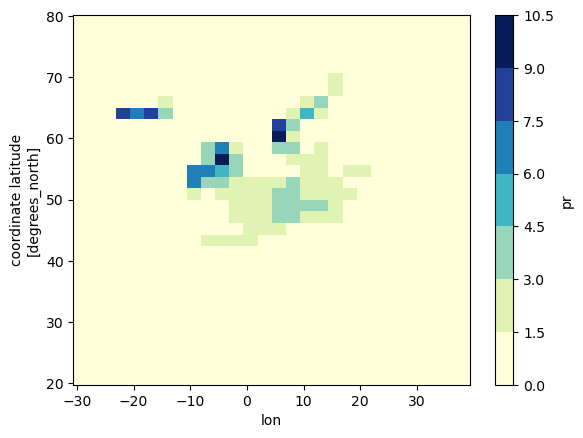

In [ ]:
pr_coarse = pr_mm.coarsen(
    lon=2, lat=2, boundary="trim"
).sum()  # for accumulated variables like precip sum() makes more sense than mean
pr_coarse.median(["time", "member_id"]).plot(cmap="YlGnBu", levels=11)

## `rolling` for rolling window operations

/Users/bandelol/mambaforge/envs/cra_env/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(np.float64(0.0), np.float64(10957.0))

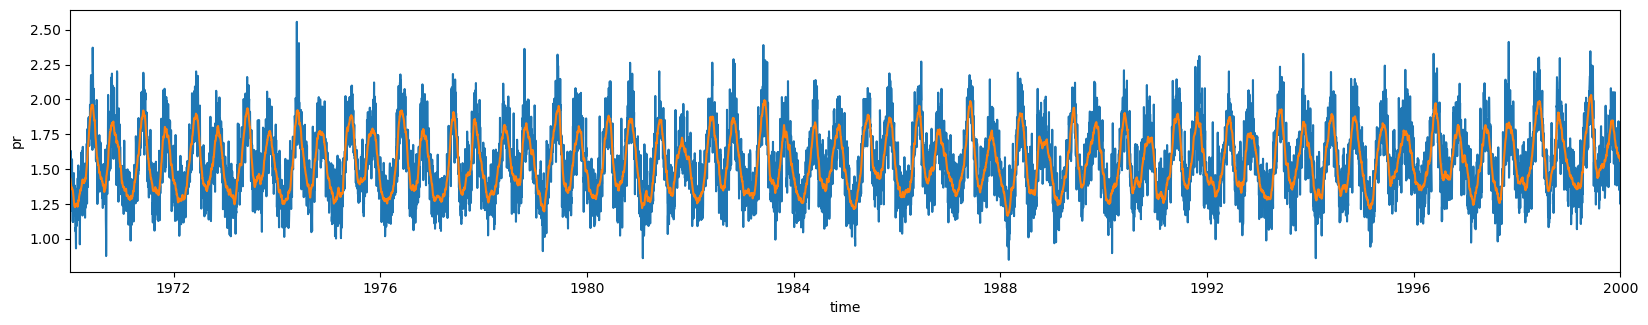

In [ ]:
import datetime
import matplotlib.pyplot as plt

ts = pr_mm.std("member_id").mean(["lon", "lat"])
ts.plot(figsize=(20, 3.4))
ts.rolling(time=31, min_periods=1, center=True).mean().plot()
plt.gca().set_xlim(
    datetime.datetime(year=1970, month=1, day=1),
    datetime.datetime(year=2000, month=1, day=1),
)

## Climatology and anomalies using `groupby`

Climatology is a broad term for a reference state against which we compare instantaneous data. The difference between instantaneous data and the corresponding climatology is called an anomaly. Here, I demonstrate how to compute a daily climatology, i.e. a reference state for every 1st of January, for every 2nd of Januaray, etc... computed by aggregating historical data for all 1st of January's, 2nd of January's, etc..., and compute anomalies from this climatology.

For good measure, we smooth our climatology using rolling window smoothing (see above) because we only care about the broad seasonal cycle and not daily or weekly signals. 

In [ ]:
# load temp data, roughly for Bern using interpolation
ds_temp = (
    xr.open_dataset(
        "PATH_TO_YOUR/TEMPERATURE_FILE.nc"
    )
    .interp(lon=7.4474, lat=46.9480)
    .reset_coords(["lon", "lat"], drop=True)
)

In [99]:
def smooth(
    da: xr.DataArray, dim: str, winsize: int
):  # pad-wrap on either side because late december is close to early january
    halfwinsize = int(np.ceil(winsize / 2))
    da = da.pad({dim: halfwinsize}, mode="wrap")
    da = da.rolling({dim: winsize}, center=True).mean()
    return da.isel({dim: slice(halfwinsize, -halfwinsize)})


gb = ds_temp.groupby("time.dayofyear")  
# xarray does magic with this object. This is not a Dataset but a GroupByObject
clim = gb.mean().mean("member_id")  
# first mean is on the GroupByObject, averages within each group and returns a Dataset, second mean() is a usual mean along one dimension of that dataset
clim = smooth(clim, "dayofyear", 31)  
# optional but recommended step: smooth your climatology using rolling window smoothing
anom = (gb - clim)  
# this is pure xarray magic, don't worry if this looks confusing. Xarray makes the substraction work between the groupbs within the GroupByObject and the corresponding climatology dayofyear.
anom

<xarray.DataArray 'TREFHT' (member_id: 10, time: 10950)> Size: 876kB
array([[-0.22935054, -1.27467182, -0.8120771 , ..., -2.97066078,
        -4.66493835, -4.26539183],
       [ 2.41058313,  2.12302694, -1.30254743, ...,  3.93875964,
         4.28483542,  2.20213138],
       [ 2.75439687,  2.59044221,  4.84420772, ..., -2.08458225,
         2.77859629,  1.77962842],
       ...,
       [ 3.98126891,  4.4266337 ,  0.84351972, ...,  0.59432431,
        -1.10404799, -3.40056231],
       [-1.17530973, -0.48628076,  2.98424507, ...,  6.59471497,
         3.52157012,  2.31204549],
       [-3.27620688, -3.13628454, -3.97303966, ..., -8.50638594,
        -2.14159801,  2.76423628]], shape=(10, 10950))
Coordinates:
  * time       (time) datetime64[ns] 88kB 1970-01-01 1970-01-02 ... 1999-12-31
  * member_id  (member_id) <U11 440B 'r1i1001p1f1' ... 'r6i1301p1f1'
    dayofyear  (time) int64 88kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

# Bonus #2: run length encoding to diagnose long lasting extreme events (heat waves, droughts, ...)

The run length encoding is a versatile algorithm used in many fields including compression. 

It turns a sequence like `["a", "a", "a", "b", "c", "c", "a"]` into 'runs' of consecutive identical values as a pair of that value and the length of the run:

`rle(["a", "a", "a", "b", "c", "c", "a"]) = [("a", 3), ("b", 1), ("c", 2), ("a", 1)]`

In climate sciences, this is useful to determine long lasting events like heat waves or droughts. A usual definition of a heatwave from a temperature time series (e.g. daily mean 2m temperature anomaly in Bern) is a period when this time series is above its 95th percentile for at least 4 consecutive days. Finding days when a timeseries is above some threshold is easy as we saw in this notebook, but the four consecutive days criterion is harder to implement. Here, I will show you one way to do it.

In [ ]:
# load temp data, roughly for Bern using interpolation, and only look at the past
# IF YOU DO NOT HAVE IT ANYMORE JUST USE THIS WEEK'S PRECIP
# It will work just as well for this demo except it's weird to call what we do heat waves
ds_temp = xr.open_dataset(
    "PATH_TO_YOUR/TEMPERATURE_FILE.nc"
)
ds_temp = (
    ds_temp.sel(time=ds_temp.time.dt.year < 2020)
    .interp(lon=7.4474, lat=46.9480)
    .reset_coords(["lon", "lat"], drop=True)["TREFHT"]
)

Compute anomalies like before

In [44]:
def smooth(
    da: xr.DataArray, dim: str, winsize: int
):  # pad-wrap on either side because late december is close to early january
    halfwinsize = int(np.ceil(winsize / 2))
    da = da.pad({dim: halfwinsize}, mode="wrap")
    da = da.rolling({dim: winsize}, center=True).mean()
    return da.isel({dim: slice(halfwinsize, -halfwinsize)})


gb = ds_temp.groupby("time.dayofyear")  
clim = gb.mean().mean("member_id")  
clim = smooth(clim, "dayofyear", 31)  
anom = gb - clim

In [45]:
q95 = anom.quantile(0.9).item()  
# I am cheating and using the 90th percentile to get more heat waves
# .item() to output a scalar instead of a zero-dimensional DataArray
print(q95)
hot_days = anom > q95
print(hot_days.mean().item())  
# should be 0.1 by definition

3.984421782573918
0.1


The algorithm relies on the very useful `itertools.groupby` which does most of the work.

Given a sequence `seq`, `groupby(seq)` is an iterator whose elements are a pair of a *key* and a *run*. The *key* is the value that is repeated once or several times in a row ("a" in our example at the start of this section) and the *run* is itself an iterator from 0 to the length of the run. The only thing we care about is the length which we get using, e.g., `sum(1 for _ in run)`. I am adding a third somewhat redundant information, the start of each run in the original `seq`, it can be useful to quickly find the run in `seq`.

In [49]:
from itertools import groupby


def get_runs(seq: np.ndarray):
    runs = []
    dtype_code = seq.dtype.char
    start = 0
    for key, run in groupby(seq):  # groupby iterates over the seq you give it
        length = sum(1 for _ in run)
        runs.append((key, start, length))
        start = start + length
    runs = np.asarray(runs, dtype=[('values', dtype_code), ('start', 'i4'), ('length', 'i4')])
    # using the nice numpy structued arrays to store our data
    return runs

In [50]:
all_runs = []
for member in hot_days.member_id.values:
    member_da = hot_days.sel(member_id=member)
    all_runs.append(get_runs(member_da.values))

In [51]:
for m, runs in enumerate(all_runs):
    member = anom.member_id[m].item()
    heat_waves_mask = (runs["length"] >= 4) & runs["values"]
    heat_waves = runs[heat_waves_mask]
    print(f"Number of heat waves in member {member}: {heat_waves_mask.sum()}")
    longest_heat_wave_index = heat_waves["length"].argmax()
    longest_heat_wave = heat_waves[longest_heat_wave_index]
    print(f"Longest heat wave in member {member}: {longest_heat_wave[2]} days")
    anom_during_longest_heatwave = anom.isel(member_id=m, time=longest_heat_wave[1] + np.arange(longest_heat_wave[2]))
    print(f"Intensity of longest heat wave in member {member}: {anom_during_longest_heatwave.sum().item()} K")
    print() # prints an empty line

Number of heat waves in member r1i1001p1f1: 90
Longest heat wave in member r1i1001p1f1: 14 days
Intensity of longest heat wave in member r1i1001p1f1: 99.47978452155445 K

Number of heat waves in member r1i1231p1f1: 89
Longest heat wave in member r1i1231p1f1: 17 days
Intensity of longest heat wave in member r1i1231p1f1: 116.72131789732612 K

Number of heat waves in member r1i1251p1f1: 88
Longest heat wave in member r1i1251p1f1: 15 days
Intensity of longest heat wave in member r1i1251p1f1: 79.34811334094604 K

Number of heat waves in member r1i1281p1f1: 88
Longest heat wave in member r1i1281p1f1: 18 days
Intensity of longest heat wave in member r1i1281p1f1: 111.78239517321373 K

Number of heat waves in member r1i1301p1f1: 85
Longest heat wave in member r1i1301p1f1: 12 days
Intensity of longest heat wave in member r1i1301p1f1: 56.438738412250814 K

Number of heat waves in member r6i1101p1f1: 84
Longest heat wave in member r6i1101p1f1: 18 days
Intensity of longest heat wave in member r6i11

# Bonus #3: The `Dask` package for parallel and distributed computing

Dask is a package that facilitates parallel (multiple CPU cores) and distributed (multiple CPUs connected together) computing. It is very well integrated to `xarray`.

The main concept dask uses to do parallel computing is the *chunking* of the data, typically a numpy array. It splits it into many smaller arrays (chunks) and handles the execution of functions cleverly on chunks.

To use its capabilities, can either call `da.chunk()` on an already created `xarray.DataArray` or create a new one from a chunked Dask array.

The second important concept with dask is *lazy computing*. Kind of as the name suggest, dask doesn't really do anything you tell it to, it only *plans* on doing it. When you actually force it to do the work, it optimizes its plan to do the least amount of work, hold the least amount of data in memory at a time, and use as much resources as possible to make the computation fast. 

In [20]:
import dask.array as darr
import xarray as xr
from dask.diagnostics import ProgressBar
rng = darr.random.default_rng()
a = rng.integers(1, 50, (int(1e5), int(1e4)))
# a is a chunked dask array (chunking is automatic but you can also specify it), we turn it into a DataArray to have named dimensions and other niceties
da = xr.DataArray(a, dims=("x", "y"), name="data")
da # a lot of data, but it's not on memory

<xarray.DataArray 'data' (x: 100000, y: 10000)> Size: 8GB
dask.array<integers, shape=(100000, 10000), dtype=int64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Dimensions without coordinates: x, y

Let's ask this dask array to do some work:

In [14]:
da.mean("x")

<xarray.DataArray 'data' (y: 10000)> Size: 80kB
dask.array<mean_agg-aggregate, shape=(10000,), dtype=float64, chunksize=(4096,), chunktype=numpy.ndarray>
Dimensions without coordinates: y

It just planned to work, but didn't do it.

Let's actually *force* it to work now. You can specify number of CPU cores used at once with `n_workers`, and how much RAM it can use (per worker) with `memory_limit`, a number of MB or a string like `"1GiB"`.

NB: dask is actually terrible at respecting memory limits in some cases and will make your notebook crash on occasions. It's just the way it is.

In [22]:
with ProgressBar():
    mean_da = da.mean("x").compute(n_workers=2, memory_limit=500)
mean_da

[########################################] | 100% Completed | 857.13 ms


<xarray.DataArray 'data' (y: 10000)> Size: 80kB
array([24.96336, 25.03959, 24.93757, ..., 24.98294, 24.97679, 24.98885],
      shape=(10000,))
Dimensions without coordinates: y

For more info, visit https://docs.xarray.dev/en/stable/user-guide/dask.html

# Exercises

In [ ]:
# let's read in rain data
input_file = (
    "PATH_TO_YOUR/RAIN_FILE.nc"
)

# let's load the data by using open_dataset function of xarray
da_pr = (
    xr.open_dataset(
        input_file, chunks={"member_id": 1, "time": 2 * 365, "lon": -1, "lat": -1}
    )
    .rename({"RAIN": "pr"})
    .load()
)["pr"]
da_pr = da_pr * 86400
da_pr.attrs["units"] = "mm/day"  # it is better to modify the attributes as well

# load temp data, roughly for Bern using interpolation, and only look at the past
# IF YOU DO NOT HAVE IT ANYMORE JUST USE THIS WEEK'S PRECIP
# It will work just as well except it's weird to call them heat waves
ds_temp = xr.open_dataset(
    "PATH_TO_YOUR/TEMPERATURE_FILE.nc"
)
temp_bern = (
    ds_temp.sel(time=ds_temp.time.dt.year < 2020)
    .interp(lon=7.4474, lat=46.9480)
    .reset_coords(["lon", "lat"], drop=True)["TREFHT"]
)

Compute the median temperature for each grid point, independently for each member and season

For the gridpoint closest to Bern, compute the monthly climatology of temperatures

For the gridpoint closest to Bern, compute the monthly mean anomalies of temperatures

A bit harder: For the gridpoint closest to Bern, the first member and only for dates before 2010, print the longest series of consecutive hot months (month whose monthly anomaly is above the 95th percentile of temperature anomalies)

In [71]:
from itertools import groupby


def get_runs(seq: np.ndarray):
    runs = []
    dtype_code = seq.dtype.char
    start = 0
    for key, run in groupby(seq):  # groupby iterates over the seq you give it
        length = sum(1 for _ in run)
        runs.append((key, start, length))
        start = start + length
    runs = np.asarray(runs, dtype=[('values', dtype_code), ('start', 'i4'), ('length', 'i4')])
    # using the nice numpy structued arrays to store our data
    return runs